## An Interpretable Approach to Classify and Explain Online Hate Speech Using LIME

### Group - 12
Group Members:
    1. Sudipta Mondal, ID: 23366020
    2. Din Mohammad Dohan, ID: 23366012
    3. Farhan Md. Siraj, ID: 22266023

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import re
import random
from collections import Counter

import warnings
warnings.filterwarnings("ignore")


import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve,auc,recall_score,precision_score
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as PL

# from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator

In [4]:
# loading dataset

df = pd.read_csv(r'E:\PROJECTS\CSE710_AI_project\Dataset\train.csv')
df.head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [5]:
# checking the shape of the data

df.shape

(31962, 3)

In [6]:
# dropping 'id' column

df = df.drop('id', axis = 'columns')

In [7]:
# let's check the shape now after dropping 'id' column

print('The shape of the data after dropping id column is {}'.format(df.shape))

The shape of the data after dropping id column is (31962, 2)


In [8]:
# checking for null values

print(f'Checking for null values in data...\n{df.isnull().sum()}')

Checking for null values in data...
label    0
tweet    0
dtype: int64


In [9]:
# let's check how many duplicates are there

df.duplicated().value_counts()

False    29530
True      2432
dtype: int64

In [10]:
# dropping Duplicates

df = df.drop_duplicates(keep='first')

In [11]:
# let's check if there is any duplicate value

df.duplicated().value_counts()

False    29530
dtype: int64

In [12]:
# now checking the shape after the drop

print(f'After checking for duplicates: The shape of the data is {df.shape}')

After checking for duplicates: The shape of the data is (29530, 2)


In [13]:
pos = 100*len(df.loc[df['label']==0,'label'])/len(df['label'])
neg = 100*len(df.loc[df['label']==1,'label'])/len(df['label'])
print(f'Percentage of Not Hate Speech (Postitive Sentiment) tweets is {pos}')
print(f'Percentage of Hate Speech (Negative Sentiment) tweets is {neg}')
# print('\nClearly, The data is heavily Imbalanced')

Percentage of Not Hate Speech (Postitive Sentiment) tweets is 93.18320352184219
Percentage of Hate Speech (Negative Sentiment) tweets is 6.816796478157806


### Visualizing The Imbalanced Data

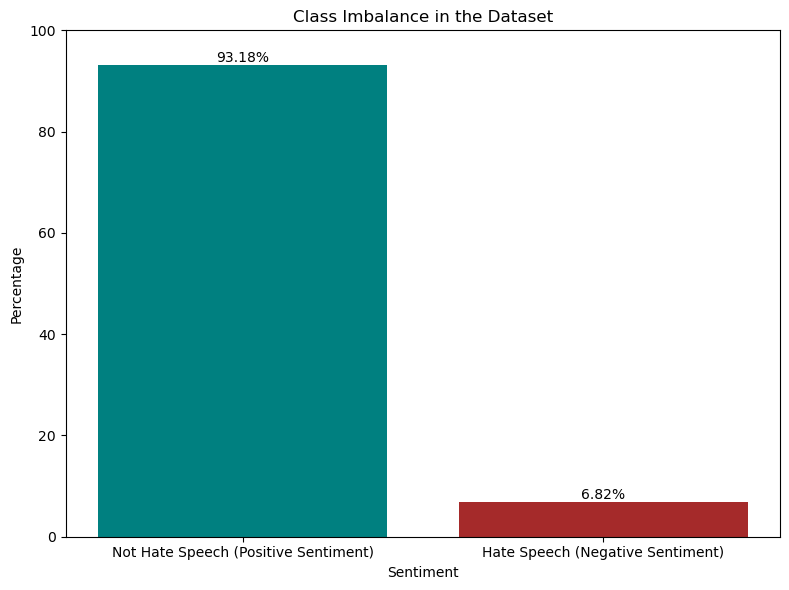

In [14]:
# Data
labels = ['Not Hate Speech (Positive Sentiment)', 'Hate Speech (Negative Sentiment)']
percentages = [pos, neg]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, percentages, color=['teal', 'brown'])
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.title('Class Imbalance in the Dataset')
plt.ylim(0, 100)  # Set the y-axis limit to 0-100 for percentages
# plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Add percentage labels above the bars
for i, p in enumerate(percentages):
    plt.annotate(f'{p:.2f}%', (labels[i], p), ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.savefig('class_imbalance_plot.png')
plt.show()


In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
stop_words = stopwords.words('english')

In [17]:
print(len(stop_words))

179


Necessary Funcions

In [18]:
# Hashtags Count

def num_of_hash_tags(df):
    df['hashtags_count'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

In [19]:
# Words Count

def num_of_words(df):
    df['word_count'] = df['tweet'].apply(lambda x : len(str(x).split(" ")))

In [20]:
# Character Count

def num_of_chars(df):
    df['char_count'] = df['tweet'].apply(lambda x: sum(list(map(len,x.split(' ')))))

In [21]:
# Number Count

def num_of_num(df):
    df['num_count'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

In [22]:
# Stopwords Count

def num_of_stop_words(df):
    df['stopwords_count'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x in stop_words]))

In [23]:
# Uppercase words

def num_of_upper(df):
    df['upper_case'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

In [24]:
# Lowercase words

def lower_case(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [25]:
# Removing Stopwords

def stop_words_remove(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

In [26]:
# Removing the word 'user'

def remove_word_user(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x != 'user'))

In [27]:
# Spell Correction

def spell_correction(df):
    df['tweet'].apply(lambda x: str(TextBlob(x).correct()))

In [28]:
# Lemmatization

Word = WordNetLemmatizer()

In [29]:
def lemmatize(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join([Word.lemmatize(word) for word in x.split()]))

Removing Hyperlinks and Markup

In [30]:
def clean(raw):
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result) # greater than sign
    result = re.sub('&#x27;', "'", result) # apostrophe
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result) # paragraph tag
    result = re.sub('<i>', ' ', result) #italics tag
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub("\n", '', result) # newline
    return result

Removing Emojis

In [31]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

Removing Punctuation and Some Symbols

In [32]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', text)
    return text

Rare Words Removal

In [33]:
lst = pd.Series(' '.join(df['tweet']).split()).value_counts()[-5:]
lst = list(lst.index)
def rare_words_removal(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in lst))

Cleaning Function

In [34]:
def cleaning(df):
    df['tweet'] = df['tweet'].apply(clean)
    df['tweet'] = df['tweet'].apply(deEmojify)
    df['tweet'] = df['tweet'].apply(lambda x: remove_punct(x))
    lower_case(df)
    stop_words_remove(df)
    remove_word_user(df)
#     rare_words_removal(df)
#     spell_correction(df)
    lemmatize(df)

In [35]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [36]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [37]:
cleaning(df)

In [38]:
df.head(20)

,label,tweet
0,0,father dysfunctional selfish drag kid dysfunct...
1,0,thanks lyft credit cant use cause dont offer w...
2,0,bihday majesty
3,0,model love u take u time ur
4,0,factsguide society motivation
5,0,huge fan fare big talking leave chaos pay disp...
6,0,camping tomorrow danny
7,0,next school year year exam cant think school e...
8,0,love land allin cavs champion cleveland clevel...
9,0,welcome im gr


In [39]:
# Separating data and labels

X = df.drop('label', axis = 'columns')
y = df['label']

In [40]:
X

,tweet
0,father dysfunctional selfish drag kid dysfunct...
1,thanks lyft credit cant use cause dont offer w...
2,bihday majesty
3,model love u take u time ur
4,factsguide society motivation
...,...
31956,fishing tomorrow carnt wait first time year
31957,ate isz youuu
31958,see nina turner airwave trying wrap mantle gen...
31959,listening sad song monday morning otw work sad


In [41]:
# defining a function to evaluate my models based on certain metrics


def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"ROC-AUC score: \n {roc_auc_score(y_train,pred)}\n")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")

In [42]:
# CounterVectorization takes any text document and 
# returns each unique word as a feature with the count of number of times that word occurs.


vector = CountVectorizer(stop_words= "english", max_features=10000, ngram_range = (1,2))

trans = vector.fit(X['tweet'])
x = trans.transform(X['tweet'])
X = X.drop('tweet', axis = 'columns')
X = pd.concat([X.reset_index(drop = True),pd.DataFrame(x.todense()).reset_index(drop = True)], axis = 'columns')
X = X.fillna(0)

In [43]:
# Dealing with imbalanced data

over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('over',over),('under', under)]
pipeline = PL(steps=steps)

X, y = pipeline.fit_resample(X, y)

In [44]:
# let's see the data now

pos = 100 * len(y[y == 0]) / len(y)
neg = 100 * len(y[y == 1]) / len(y)

print(f'Percentage of Not Hate Speech (Positive Sentiment) tweets is {pos}')
print(f'Percentage of Hate Speech (Negative Sentiment) tweets is {neg}')

Percentage of Not Hate Speech (Positive Sentiment) tweets is 66.66666666666667
Percentage of Hate Speech (Negative Sentiment) tweets is 33.333333333333336


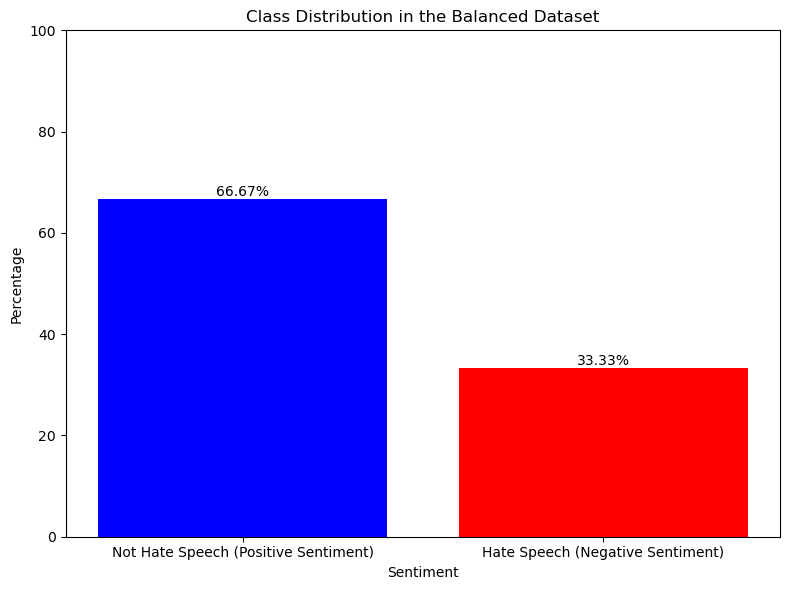

In [45]:
# visualising the data after SMOTE and RandomUnderSampler

# Data
labels = ['Not Hate Speech (Positive Sentiment)', 'Hate Speech (Negative Sentiment)']
percentages = [pos, neg]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, percentages, color=['blue', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.title('Class Distribution in the Balanced Dataset')
plt.ylim(0, 100)  # Set the y-axis limit to 0-100 for percentages

# Add percentage labels above the bars
for i, p in enumerate(percentages):
    plt.annotate(f'{p:.2f}%', (labels[i], p), ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.savefig('class_Balanced_plot.png')
plt.show()


In [46]:
# Standard stratified train test split being done here but other validation strategies can be explored

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,
                                                   test_size = 0.25,stratify=y)

## Multinomial Naive Bayes Classifier

In [47]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train,y_train)

#predicting test results
pred= nb_classifier.predict(X_test)

In [48]:
nb_cm = confusion_matrix(y_test,pred)
print(nb_cm)
nb_score = accuracy_score( y_test, pred)
print(nb_score)

[[5176  327]
 [1626 1126]]
0.7634161114476075


In [49]:
print("Classification Report")
print(classification_report(y_test, pred))

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.94      0.84      5503
           1       0.77      0.41      0.54      2752

    accuracy                           0.76      8255
   macro avg       0.77      0.67      0.69      8255
weighted avg       0.77      0.76      0.74      8255



## Random Forest

In [50]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Predicting test results
rf_pred = rf_classifier.predict(X_test)

In [51]:
rf_cm = confusion_matrix(y_test, rf_pred)
print(rf_cm)
rf_score = accuracy_score(y_test, rf_pred)
print(rf_score)

[[4933  570]
 [ 174 2578]]
0.9098728043609934


In [52]:
print("Classification Report")
print(classification_report(y_test, rf_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      5503
           1       0.82      0.94      0.87      2752

    accuracy                           0.91      8255
   macro avg       0.89      0.92      0.90      8255
weighted avg       0.92      0.91      0.91      8255



## KNN Classifier

In [53]:
knn_classifier = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn_classifier.fit(X_train, y_train)

#predicting test results
knn_pred = knn_classifier.predict(X_test)

In [54]:
knn_cm=confusion_matrix(y_test, knn_pred)
print(knn_cm)
knn_score = accuracy_score( y_test, knn_pred)
print(knn_score)

[[2959 2544]
 [  48 2704]]
0.6860084797092671


In [55]:
print("Classification Report")
print(classification_report(y_test, knn_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.54      0.70      5503
           1       0.52      0.98      0.68      2752

    accuracy                           0.69      8255
   macro avg       0.75      0.76      0.69      8255
weighted avg       0.83      0.69      0.69      8255



## Logistic Regression

In [56]:
lr_classifier = LogisticRegression(random_state = 0)
lr_classifier.fit(X_train, y_train)

print("Test  Accuracy : %.2f"%lr_classifier.score(X_test, y_test))
print("Train Accuracy : %.2f"%lr_classifier.score(X_train, y_train))
print()

#predicting test results
y_pred = lr_classifier.predict(X_test)

Test  Accuracy : 0.92
Train Accuracy : 0.95



In [57]:
lr_cm=confusion_matrix(y_test,y_pred)
print(lr_cm)
lr_score = accuracy_score( y_test, y_pred)
print(lr_score)

[[5030  473]
 [ 184 2568]]
0.920411871592974


In [58]:
print("Classification Report")
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      5503
           1       0.84      0.93      0.89      2752

    accuracy                           0.92      8255
   macro avg       0.90      0.92      0.91      8255
weighted avg       0.92      0.92      0.92      8255



## Support Vector Machine

In [59]:
from sklearn import svm
classifier = svm.SVC(kernel='linear',random_state = 0)
classifier.fit(X_train, y_train)

print("Test  Accuracy : %.2f"%classifier.score(X_test, y_test))
print("Train Accuracy : %.2f"%classifier.score(X_train, y_train))
print()

#predicting test results
svm_pred = classifier.predict(X_test)

Test  Accuracy : 0.92
Train Accuracy : 0.97



In [60]:
cm=confusion_matrix(y_test,svm_pred)
print(cm)
score = accuracy_score( y_test, svm_pred)
print(score)

[[5001  502]
 [ 162 2590]]
0.9195639006662629


In [61]:
print("Classification Report")
print(classification_report(y_test, svm_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      5503
           1       0.84      0.94      0.89      2752

    accuracy                           0.92      8255
   macro avg       0.90      0.92      0.91      8255
weighted avg       0.92      0.92      0.92      8255



In [65]:
# Make dataframes to plot

nb_df = pd.DataFrame(data=[f1_score(y_test,pred),accuracy_score(y_test, pred), recall_score(y_test, pred),
                   precision_score(y_test, pred), roc_auc_score(y_test, pred)], 
             columns=['Naive Bayes Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

rf_df = pd.DataFrame(data=[f1_score(y_test, rf_pred), accuracy_score(y_test, rf_pred), recall_score(y_test, rf_pred),
                           precision_score(y_test, rf_pred), roc_auc_score(y_test, rf_pred)], 
                     columns=['Random Forest Score'],
                     index=["F1", "Accuracy", "Recall", "Precision", "ROC AUC Score"])


kn_df = pd.DataFrame(data=[f1_score(y_test, knn_pred),accuracy_score(y_test, knn_pred), recall_score(y_test, knn_pred),
                   precision_score(y_test, knn_pred), roc_auc_score(y_test, knn_pred)], 
             columns=['K-neighbor Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

lr_df = pd.DataFrame(data=[f1_score(y_test,y_pred),accuracy_score(y_test, y_pred), recall_score(y_test, y_pred),
                   precision_score(y_test, y_pred), roc_auc_score(y_test, y_pred)], 
             columns=['Logistic Regression Score'],
              index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])     

svm_df = pd.DataFrame(data=[f1_score(y_test,svm_pred),accuracy_score(y_test, svm_pred), recall_score(y_test, svm_pred),
                   precision_score(y_test, svm_pred), roc_auc_score(y_test, svm_pred)], 
             columns=['Support Vector Machine (SVM) Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])


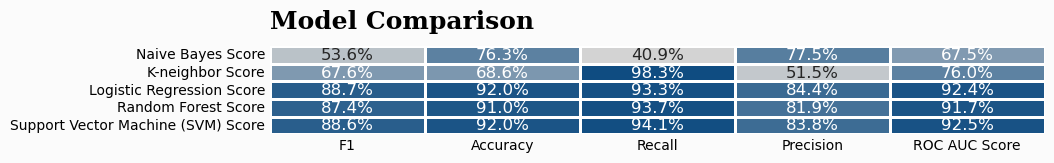

In [67]:
df_models = round(pd.concat([nb_df, kn_df, lr_df, rf_df, svm_df], axis=1), 3)

import matplotlib

colors = ["lightgray", "lightgray", "#0f4c81"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

background_color = "#fbfbfb"

fig = plt.figure(figsize=(10, 8))  # create figure
gs = fig.add_gridspec(5, 2)  # Increase the grid rows by 1 to accommodate Random Forest
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

sns.heatmap(df_models.T, cmap=colormap, annot=True, fmt=".1%", vmin=0, vmax=0.95, linewidths=1, cbar=False,
            ax=ax0, annot_kws={"fontsize": 12})
fig.patch.set_facecolor(background_color)  # figure background color
ax0.set_facecolor(background_color)

ax0.text(0, -1, 'Model Comparison', fontsize=18, fontweight='bold', fontfamily='serif')
ax0.tick_params(axis=u'both', which=u'both', length=0)

plt.show()


### ROC AUC Score

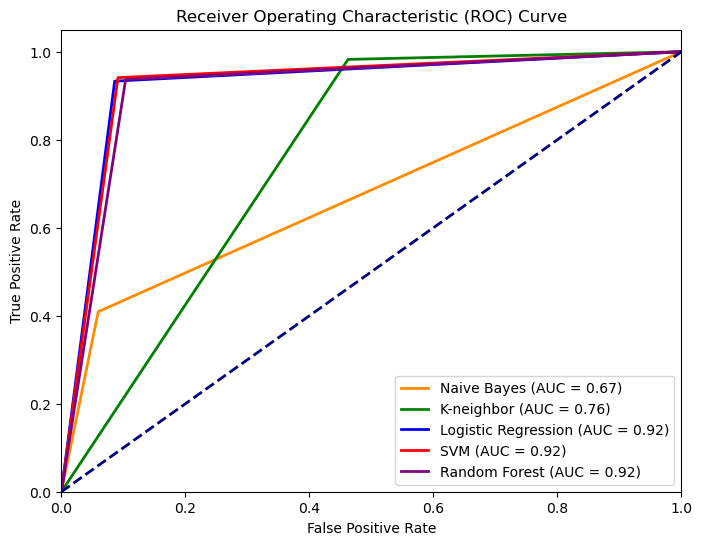

In [68]:

# Calculate ROC curve and AUC for each model
fpr_nb, tpr_nb, _ = roc_curve(y_test, pred)
roc_auc_nb = auc(fpr_nb, tpr_nb)

fpr_kn, tpr_kn, _ = roc_curve(y_test, knn_pred)
roc_auc_kn = auc(fpr_kn, tpr_kn)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_pred)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred)  
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curves for all models
plt.figure(figsize=(8, 6))

plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
plt.plot(fpr_kn, tpr_kn, color='green', lw=2, label=f'K-neighbor (AUC = {roc_auc_kn:.2f})')
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_svm, tpr_svm, color='red', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_rf, tpr_rf, color='purple', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})') 

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## LIME - Local Interpretable Model-agnostic Explanations

In [ ]:
pip install lime

In [69]:
dftest = pd.read_csv(r'E:\PROJECTS\CSE710_AI_project\Dataset\test.csv')

dftest.head(10)

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."
5,31968,choose to be :) #momtips
6,31969,something inside me dies ð¦ð¿â¨ eyes nes...
7,31970,#finished#tattoo#inked#ink#loveitâ¤ï¸ #â¤ï¸...
8,31971,@user @user @user i will never understand why...
9,31972,#delicious #food #lovelife #capetown mannaep...


In [70]:
train_text = df['tweet']
test_text = dftest['tweet']
all_text = pd.concat([train_text, test_text])

In [71]:
all_text

0        father dysfunctional selfish drag kid dysfunct...
1        thanks lyft credit cant use cause dont offer w...
2                                           bihday majesty
3                              model love u take u time ur
4                            factsguide society motivation
                               ...                        
17192    thought factory: left-right polarisation! #tru...
17193    feeling like a mermaid ð #hairflip #neverre...
17194    #hillary #campaigned today in #ohio((omg)) &am...
17195    happy, at work conference: right mindset leads...
17196    my   song "so glad" free download!  #shoegaze ...
Name: tweet, Length: 46727, dtype: object

In [72]:
# using vectorizer

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)

word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

## Logistic Regression Classifier

In [73]:
train_target_hate_speech = df['label']
classifier_hate_speech = LogisticRegression(C=0.1, solver='sag')
classifier_hate_speech.fit(train_word_features, train_target_hate_speech)

LogisticRegression(C=0.1, solver='sag')

In [74]:
names=['hate_speech','not hate_speech']

In [75]:
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

c_tf = make_pipeline( word_vectorizer,classifier_hate_speech)
explainer_tf = LimeTextExplainer(class_names = names)

In [198]:
idx = random.randint(1, len(test_text))
exp = explainer_tf.explain_instance(train_text.iloc[idx], c_tf.predict_proba, num_features=10, top_labels=1)
exp.show_in_notebook(text=train_text.iloc[idx])

